In [1]:
# from utils import datagenerator
from utils.shape import ShapesConfig
from coco import CocoDataset
import matplotlib.pyplot as plt
from utils.datagenerator import data_generator

from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
import keras.layers as KL
import keras.models as KM
import tensorflow as tf
import numpy as np

from utils.BilinearUpSampling import *
from utils.Mylayers import *
from utils.model import *
import keras
# import utils

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[56 56]
 [28 28]
 [14 14]
 [ 7  7]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  224
IMAGE_MIN_DIM                  224
IMAGE_PADDING                  True
IMAGE_SHAPE                    [224 224   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         20

In [3]:
dataset_train = CocoDataset()
dataset_train.load_coco('coco_dataset/', "val")
dataset_train.prepare()

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [4]:
def side_branch(x, factor, stage):
    conv_name = "edge_conv_" + str(stage)
    trans_conv_name = "edge_transconv_" + str(stage)
    x = Conv2D(81, (1, 1), activation=None, padding='same', name= conv_name)(x)

    kernel_size = (2*factor, 2*factor)
    x = Conv2DTranspose(81, kernel_size, strides=factor, padding='same',name = trans_conv_name, use_bias=False, activation=None)(x)

    return x
def tran_conv(x,y,stage):
    conv_name = "edge_conv_" + str(stage)
    edge = KL.Add()([x,y])
#     x = KL.concatenate([x,y])
    edge = KL.Conv2D(81, (2, 2) , padding="same")(edge)
    edge = KL.Add()([edge,y])
    x = KL.Conv2D(81, (1, 1) , padding="same")(x)    
    edge = KL.Add()([edge,y])
#     edge = KL.BatchNormalization(axis=3)(edge)
#     edge = KL.Activation('relu')(edge)
    return edge

def build_resblock(input_layer,factor):
    tmp = KL.Conv2D(256, (factor, factor) , padding="same")(input_layer)
    tmp = KL.BatchNormalization(axis=3)(tmp)
    tmp = KL.Activation('relu')(tmp)
    tmp = KL.Conv2D(256, (factor, factor) , padding="same")(tmp)
    tmp = KL.BatchNormalization(axis=3)(tmp)
#     tmp = KL.Activation('relu')(tmp)
    
    tmp = KL.Add()([input_layer,tmp])
#     tmp = KL.BatchNormalization(axis=3)(tmp)
#     tmp = KL.Activation('relu')(tmp)
    
    return tmp

In [5]:
def generate_model(input_image, input_image_56):
    #resnet
    res_model,C1,C2,C3,C4,C5 = resnet_graph(input_image, "resnet50", stage5=True)
    
    for layer in res_model.layers:
        layer.trainable=False
    
#     S1 = side_branch(C1,1)
#     S2 = side_branch(C2,1)
#     S3 = side_branch(C3,2)
#     S4 = side_branch(C4,4)
#     S5 = side_branch(C5,8)        
        
    
#     C5 = KL.Conv2D(2048, (2, 2) , padding="same")(C5)
#     C4 = KL.Conv2D(1024, (2, 2) , padding="same")(C4)
#     C3 = KL.Conv2D(512, (2, 2) , padding="same")(C3)
#     C2 = KL.Conv2D(256, (2, 2) , padding="same")(C2)
    
    P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
    P4 = KL.Add(name="fpn_p4add")([
        BilinearUpSampling2D(target_size=(14, 14))(P5),
        KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
    P3 = KL.Add(name="fpn_p3add")([
        BilinearUpSampling2D(target_size=(28, 28))(P4),
        KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
    P2 = KL.Add(name="fpn_p2add")([
        BilinearUpSampling2D(target_size=(56, 56))(P3),
        KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
    
    P1 = KL.Conv2D(3,(2,2), padding="SAME") (input_image_56)
#     P1 = KL.BatchNormalization(axis=3)(P1)
#     P1 = KL.Activation('relu')(P1)
    P1 = KL.concatenate([P1,C1])
    P1 = KL.Conv2D(256,(1,1), padding="SAME") (input_image_56)
#     P1 = KL.BatchNormalization(axis=3)(P1)
#     P1 = KL.Activation('relu')(P1)
    P1 = KL.Add(name="fpn_p1add")([P2,P1])
    
    # Attach 3x3 conv to all P layers to get the final feature maps.
    P2 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
#     P2 = KL.BatchNormalization(axis=3)(P2)
#     P2 = KL.Activation('relu')(P2)
    P3 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
#     P3 = KL.BatchNormalization(axis=3)(P3)
#     P3 = KL.Activation('relu')(P3)
    P4 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
#     P4 = KL.BatchNormalization(axis=3)(P4)
#     P4 = KL.Activation('relu')(P4)
    P5 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
#     P5 = KL.BatchNormalization(axis=3)(P5)
#     P5 = KL.Activation('relu')(P5)

    P5 = build_resblock(P5,1)
    P5 = build_resblock(P5,1)
    P4 = build_resblock(P4,2)
    P4 = build_resblock(P4,2)
    P3 = build_resblock(P3,4)
    P3 = build_resblock(P3,4)
    P2 = build_resblock(P2,8)
    P2 = build_resblock(P2,8)
    P1 = build_resblock(P1,8)
    P1 = build_resblock(P1,8)

    
    P1 = KL.Conv2D(81, (1, 1), padding="SAME")(P1)
#     P1 = KL.BatchNormalization(axis=3)(P1)
#     P1 = KL.Activation('relu')(P1)
    P2 = KL.Conv2D(81, (1, 1), padding="SAME")(P2)
#     P2 = KL.BatchNormalization(axis=3)(P2)
#     P2 = KL.Activation('relu')(P2)
    P3 = KL.Conv2D(81, (1, 1), padding="SAME")(P3)
#     P3 = KL.BatchNormalization(axis=3)(P3)
#     P3 = KL.Activation('relu')(P3)
    P4 = KL.Conv2D(81, (1, 1), padding="SAME")(P4)
#     P4 = KL.BatchNormalization(axis=3)(P4)
#     P4 = KL.Activation('relu')(P4)
    P5 = KL.Conv2D(81, (1, 1), padding="SAME")(P5)
#     P5 = KL.BatchNormalization(axis=3)(P5)
#     P5 = KL.Activation('relu')(P5)

#     T1 = BilinearUpSampling2D(target_size=(14, 14))(P5)
#     T2 = tran_conv(T1,P4,14)
#     T2 = BilinearUpSampling2D(target_size=(28, 28))(T2)
#     T3 = tran_conv(T2,P3,28)
#     T3 = BilinearUpSampling2D(target_size=(56, 56))(T3)
#     T4 = tran_conv(T3,P2,56)
#     T5 = tran_conv(T4,P1,56)
#     T5 = KL.BatchNormalization(axis=3)(T5)
#     T5 = KL.Activation('relu')(T5)
    
#     U1 = BilinearUpSampling2D(target_size=(56, 56))(P5)
#     U2 = BilinearUpSampling2D(target_size=(56, 56))(P4)
#     U3 = BilinearUpSampling2D(target_size=(56, 56))(P3)
#     U1 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(U1)
#     U2 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(U2)
#     U3 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(U3)
#     U4 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(P2)
#     U5 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(P1)
#     T5 = KL.Reshape((56,56*81,1), input_shape=(56,56,81))(T5)
#     U = KL.concatenate([T5,U1,U2,U3,U4,U5])
#     U = KL.Conv2D(1, (1,1) , padding="SAME")(U)
#     U = KL.Reshape((56,56,81), input_shape=(56,56*81,1))(U)
    
#     P5 = build_resblock(P5,1)
#     P4 = build_resblock(P4,1)
#     P3 = build_resblock(P3,1)
#     P2 = build_resblock(P2,1)
    
#     P5 = build_resblock(P5,1)
#     P4 = build_resblock(P4,1)
#     P3 = build_resblock(P3,1)
#     P2 = build_resblock(P2,1)
    
    
    y = BilinearUpSampling2D(target_size=(14, 14))(P5)
    y = KL.Add()([y,P4])
    y = BilinearUpSampling2D(target_size=(28, 28))(y)
    y = KL.Add()([y,P3])
    y = BilinearUpSampling2D(target_size=(56, 56))(y)
    y = KL.Add()([y,P2])
    y = KL.BatchNormalization(axis=3)(y)
    y = KL.Activation('relu')(y)
    y = KL.Add()([y,P1])
    y = KL.BatchNormalization(axis=3)(y)
    y = KL.Activation('relu')(y)
    tmp_output = y
    
    # P6 is used for the 5th anchor scale in RPN. Generated by
    # subsampling from P5 with stride of 2.
#     P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)
    
    
    y = KL.Reshape((56*56,81) , input_shape= (56,56,81))(y)
    print("y : {} ".format(y))
    y = KL.Activation('softmax')(y)
    print("y : {} ".format(y))
    
#     y = KL.Permute((2, 1), input_shape=(3136, 81))(y)
#     print("y : {} ".format(y))
    
    
    
    
    model = KM.Model(inputs=[input_image,input_image_56],outputs=y)
    return model, tmp_output, C1

In [6]:
def overal_model(mode,input_image, input_image_56):
    mode = mode
    
    back_model, y, C1 = generate_model(input_image,input_image_56)
#     back_model.load_weights("FCN_background_testing.hdf5")
    
#     #VGG net to find location
#      # Block 1 224
#     P1 = KL.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_image)
#     P1 = KL.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(P1)
    

#     # Block 2 112
#     P2 = KL.MaxPooling2D((2, 2), strides=(2, 2), name='vgg_block2_pool')(P1)
#     P2 = KL.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(P2)
#     P2 = KL.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(P2)
    

#     # Block 3 56
#     P3 = KL.MaxPooling2D((2, 2), strides=(2, 2), name='vgg_block3_pool')(P2)
#     P3 = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(P3)
#     P3 = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(P3)
#     P3 = KL.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(P3)

    
    
    P3 = KL.Conv2D(81, (2,2),activation='relu', padding="same")(C1)
    P3 = KL.Add()([P3,y])
    S3 = side_branch(P3,1,1)
    S3 = tran_conv(P3,S3,2)
    
    P2 = BilinearUpSampling2D(target_size=(112, 112))(C1)
    P3 = BilinearUpSampling2D(target_size=(112, 112))(P3)
    P2 = KL.Conv2D(81, (2,2),activation='relu', padding="same")(P2)    
    P2 = KL.Add()([P2,P3])
    S2 = side_branch(P2,1,3)
    S2 = tran_conv(P2,S2,4)
    
#     P2 = BilinearUpSampling2D(target_size=(224, 224))(intput_image)
    P1 = KL.Conv2D(81, (2,2),activation='relu', padding="same")(input_image)
    P2 = BilinearUpSampling2D(target_size=(224, 224))(P2)
    P1 = KL.Add()([P1,P2])
    S1 = side_branch(P1,1,5)
    S1 = tran_conv(P1,S1,6)
    
    S3 = BilinearUpSampling2D(target_size=(224, 224))(S3)
    S2 = BilinearUpSampling2D(target_size=(224, 224))(S2)
    S = KL.Add()([S1,S2,S3])
#     S = KL.Conv2D(81,(1,1),activation='relu', padding="same",name="edge_conv_final")(S)
    
    O = KL.Reshape((224*224,81) , input_shape= (224,224,81) )(P1)
    print(O)
    O1 = KL.Activation('softmax')(O)
    print(O1)
    
    O2 = KL.Reshape((224*224,81) , input_shape= (224,224,81))(S)
    print(O2)
    O2 = KL.Activation('sigmoid')(O2)
    print(O2)

    
    if mode == "training":
        
        model = KM.Model(inputs=[input_image, input_image_56],outputs=[O1,O2])
        
#         edge_loss = K.mean(K.binary_crossentropy(test_image, O2), axis=-1)
#         mask_loss = K.categorical_crossentropy(test_mask, O1)
        
#         sum_edge_loss = tf.reduce_sum(edge_loss)
#         sum_mask_loss = tf.reduce_sum(mask_loss)
        
#         check = 0
#         check = tf.where(tf.greater(sum_edge_loss , sum_mask_loss), 0, 1)
#         if check==0:
#             print("edge")
#             model = KM.Model(inputs=[input_image,input_image_56],outputs=[O1,O2])            
#             model.compile(optimizer=sgd, loss= 'binary_crossentropy', metrics=['accuracy'])
#             model.loss = sum_edge_loss
            

#         else:
#             print("mask")
#             model = KM.Model(inputs=[input_image, input_image_56,test_image,test_mask],outputs=[O1,O2])            
#             model.compile(optimizer=sgd, loss= 'categorical_crossentropy', metrics=['accuracy'])
#             model.loss = sum_mask_loss
            
    else : 
        model = KM.Model(inputs=[input_image, input_image_56],outputs=O1)
#         model.compile(optimizer=sgd, loss= [None], metrics=['accuracy'])
#     model1 = KM.Model(inputs=[input_image,input_image_56],outputs=O1)
#     model2 = KM.Model(inputs=[input_image,input_image_56],outputs=O2)
    
    return model

In [7]:
from keras.optimizers import SGD,Adam
sgd = SGD(lr = config.LEARNING_RATE, decay=1e-6, momentum=config.LEARNING_MOMENTUM, nesterov=True)

In [8]:
mode="training"
input_image = KL.Input(shape=[224,224,3], name="g_input_data")
input_image_56 = KL.Input(shape=[56,56,3], name="g_input_data_56")
test_image = KL.Input(shape=[224,224,3], name="test_image")
test_mask = KL.Input(shape=[224*224,81], name="test_mask")
Model = overal_model(mode,input_image, input_image_56)

input_image : Tensor("g_input_data:0", shape=(?, 224, 224, 3), dtype=float32) 
C1 : Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 56, 56, 64), dtype=float32) 
C2 : Tensor("res2c_out/Relu:0", shape=(?, 56, 56, 256), dtype=float32) 
C3 : Tensor("res3d_out/Relu:0", shape=(?, 28, 28, 512), dtype=float32) 
C4 : Tensor("res4f_out/Relu:0", shape=(?, 14, 14, 1024), dtype=float32) 
C5 : Tensor("res5c_out/Relu:0", shape=(?, 7, 7, 2048), dtype=float32) 
xfc Flatten : Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32) 
xfc Dense : Tensor("fc1000/Softmax:0", shape=(?, 1000), dtype=float32) 
y : Tensor("reshape_1/Reshape:0", shape=(?, 3136, 81), dtype=float32) 
y : Tensor("activation_46/truediv:0", shape=(?, 3136, 81), dtype=float32) 
Tensor("reshape_2/Reshape:0", shape=(?, 50176, 81), dtype=float32)
Tensor("activation_47/truediv:0", shape=(?, 50176, 81), dtype=float32)
Tensor("reshape_3/Reshape:0", shape=(?, 50176, 81), dtype=float32)
Tensor("activation_48/Sigmoid:0", shape=(?, 50176, 81), 

In [9]:
# Model.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5",by_name="True")

In [10]:
Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
g_input_data (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           g_input_data[0][0]               
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
# Model.compile(optimizer=sgd, loss= 'categorical_crossentropy', metrics=['accuracy'])
# g_model.compile(optimizer=sgd, loss= 'binary_crossentropy', metrics=['accuracy'])
Model.compile(optimizer=sgd, loss=['categorical_crossentropy', 'binary_crossentropy'], metrics=['accuracy'],loss_weights=[1, 0])

In [12]:
config.USE_MINI_MASK = True
config.MINI_MASK_SHAPE = (224,224)
train_generator = data_generator(dataset_train, config, shuffle=True,batch_size=config.BATCH_SIZE,use_background=True)

In [13]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, Model, log = {}):
#         self.model = Model
        self.mask_loss_name = Model.output_names[0]+"_loss"
        self.edge_loss_name = Model.output_names[1]+"_loss"
        self.pre_mask_loss = 0
        self.pre_edge_loss = 0
        self.total_mask_gap = 0
        self.total_edge_gap = 0
        self.mask_weight = 1
        self.edge_weight = 0
        print("OK")
        
    def on_train_begin(self, logs={}):
        print("Starting Training")
        for layer in Model.layers:
            if "edge" in layer.name:
                layer.trainable = False
        return
    def on_epoch_begin(self, echo, logs={}):
        trainable_count = int(
            np.sum([K.count_params(p) for p in set(Model.trainable_weights)]))
        non_trainable_count = int(
            np.sum([K.count_params(p) for p in set(Model.non_trainable_weights)]))        
        
        if self.mask_weight == 1:
            
            print("\x1b[32m\"Train Mask\"\x1b[0m")
            print("\x1b[32m\"Total params: {:,}\"\x1b[0m".format(trainable_count + non_trainable_count))
            print("\x1b[32m\"Trainable params: {:,}\"\x1b[0m".format(trainable_count))
            print("\x1b[32m\"Non-trainable params: {:,}\"\x1b[0m".format(non_trainable_count))
            
        else:
            
            print("\x1b[34m\"Train Edge\"\x1b[0m")
            print("\x1b[34m\"Total params: {:,}\"\x1b[0m".format(trainable_count + non_trainable_count))
            print("\x1b[34m\"Trainable params: {:,}\"\x1b[0m".format(trainable_count))
            print("\x1b[34m\"Non-trainable params: {:,}\"\x1b[0m".format(non_trainable_count))
            
        return

    def on_epoch_end(self, echo, logs={}):
        print("\n")
        self.total_mask_gap += abs(self.pre_mask_loss - logs.get(self.mask_loss_name))
        self.total_edge_gap += abs(self.pre_edge_loss - logs.get(self.edge_loss_name))
        print("\x1b[31m\"Total Mask Loss GAP : {}\"\x1b[0m".format(self.total_mask_gap))
        print("\x1b[31m\"Total Edge Loss GAP : {}\"\x1b[0m".format(self.total_edge_gap))
        if self.total_mask_gap > self.total_edge_gap:
            self.mask_weight = 1
            self.edge_weight = 0
            
            #if trained , total gap clear
            self.total_mask_gap = 0
            
            self.pre_mask_loss = float(logs.get(self.mask_loss_name))
            for layer in Model.layers:
                if "edge" in layer.name:
                    layer.trainable = False
        else:
            self.mask_weight = 0
            self.edge_weight = 1
            
            #if trained , total gap clear
            self.total_edge_gap = 0
            
            self.pre_edge_loss = float(logs.get(self.edge_loss_name))
            for layer in Model.layers:
                if "edge" in layer.name:
                    layer.trainable = True
                    
        Model.compile(optimizer=sgd, loss=['categorical_crossentropy', 'binary_crossentropy'], metrics=['accuracy'],loss_weights=[self.mask_weight, self.edge_weight])
        
        
        return

In [14]:
callback = MyCallback(Model)

OK


In [ ]:
Model.fit_generator(train_generator,
            epochs=10,
            steps_per_epoch=100,callbacks=[callback])

Starting Training
"Train Mask"
"Total params: 66,343,229"
"Trainable params: 42,646,295"
"Non-trainable params: 23,696,934"
Epoch 1/10


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 99/100 [============================>.] - ETA: 2s - loss: 0.4708 - activation_47_loss: 0.4708 - activation_48_loss: 3.3318 - activation_47_acc: 0.9237 - activation_48_acc: 0.4984

"Total Mask Loss GAP : 0.4692698376160115"
"Total Edge Loss GAP : 3.3310713958740235"
100/100 [==============================] - 210s 2s/step - loss: 0.4693 - activation_47_loss: 0.4693 - activation_48_loss: 3.3311 - activation_47_acc: 0.9242 - activation_48_acc: 0.4985
"Train Edge"
"Total params: 66,343,229"
"Trainable params: 42,744,953"
"Non-trainable params: 23,598,276"
Epoch 2/10
 99/100 [============================>.] - ETA: 2s - loss: 0.1020 - activation_47_loss: 0.4845 - activation_48_loss: 0.1020 - activation_47_acc: 0.9628 - activation_48_acc: 0.9810

"Total Mask Loss GAP : 0.9570933845173568"
"Total Edge Loss GAP : 3.2300600686995313"
100/100 [==============================] - 216s 2s/step - loss: 0.1010 - activation_47_loss: 0.4878 - activation_48_loss: 0.1010 - activation_47_acc: 0.9625 - activ

In [17]:
Model.save_weights("Model_testing.hdf5",overwrite=True)

In [10]:
Model.load_weights("Model_testing.hdf5")

In [15]:
from utils.datagenerator import load_image_gt
import numpy as np
import random
import scipy.misc

In [16]:
image, gt_class_ids, gt_masks, gt_all_masks = \
                load_image_gt(dataset_train, config, random.randint(0,150), augment=True,
                          use_mini_mask=config.USE_MINI_MASK,use_background=True)

<IPython.core.display.Javascript object>


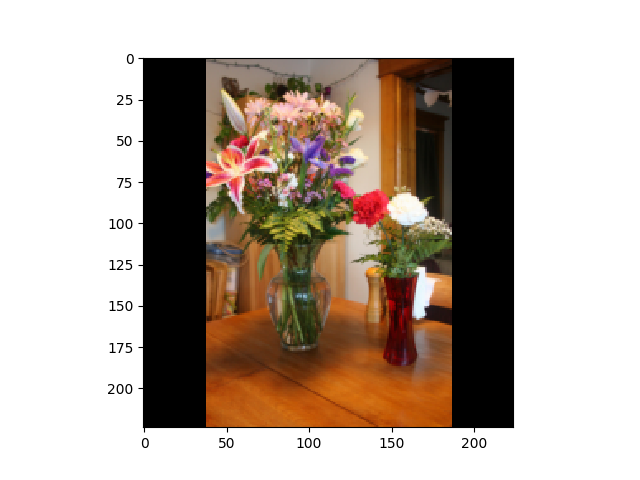

In [17]:
%matplotlib notebook
plt.imshow(image)
plt.show()

In [18]:
x = np.expand_dims(image, axis=0)
x1 = np.expand_dims(scipy.misc.imresize(image,(56,56)), axis=0)
# x2 = np.expand_dims(image,axis=0)
print(x.shape)
x2 = np.zeros((1,50176,81))
output_mask,output_edge = Model.predict([x,x1])
output_mask = np.reshape(output_mask[0,:,:],(224,224,81))
output_edge = np.reshape(output_edge[0,:,:],(224,224,81))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


(1, 224, 224, 3)


In [19]:
gt_class_ids

array([76, 76, 61, 57, 57, 57], dtype=int32)

<IPython.core.display.Javascript object>


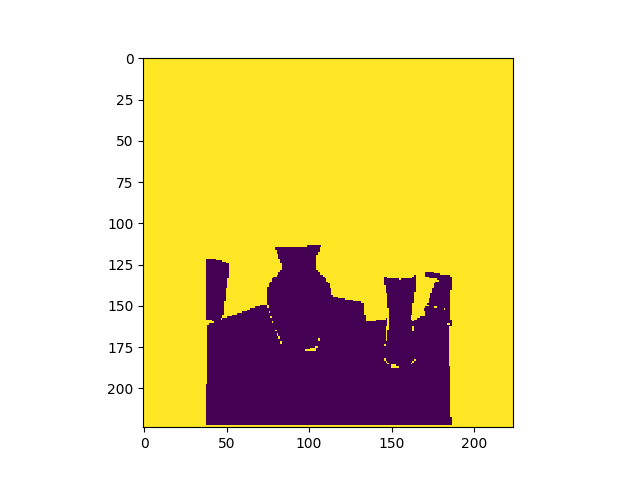

In [22]:
%matplotlib notebook
plt.imshow(gt_masks[:,:,0])
plt.show()

<IPython.core.display.Javascript object>


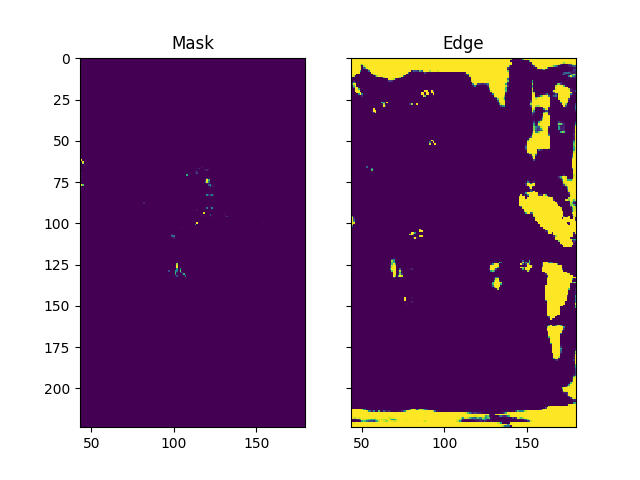

In [21]:
#before train
%matplotlib notebook
class_id = 1
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(output_mask[:,:,class_id])
ax1.set_title('Mask')
ax2.imshow(output_edge[:,:,class_id])
ax2.set_title('Edge')
plt.show()

<IPython.core.display.Javascript object>


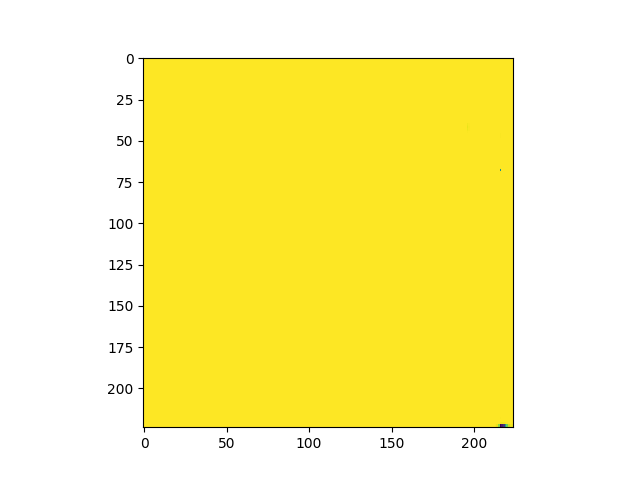

In [23]:
%matplotlib notebook
class_id = 0
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(output_mask[:,:,class_id])
ax1.set_title('Mask')
ax2.imshow(output_edge[:,:,class_id])
ax2.set_title('Edge')
plt.show()